In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Path dataset
original_dataset_path = r"E:/Semester 7/Praktikum ML/datasetUAP/dataset/"

# Path untuk folder baru
train_path = os.path.join(original_dataset_path, 'train/')
validation_path = os.path.join(original_dataset_path, 'validation/')
test_path = os.path.join(original_dataset_path, 'test/')

# Kelas dataset
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Pembagian ratio train, validation, dan test
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Membuat folder baru jika belum ada
os.makedirs(train_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

for class_name in classes:
    class_path = os.path.join(original_dataset_path, class_name)
    # Buat folder untuk kelas di setiap subset
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # Ambil semua gambar di kelas ini
    images = os.listdir(class_path)

    # Tentukan jumlah gambar untuk setiap subset
    num_images = len(images)
    num_train_images = int(num_images * train_ratio)
    num_validation_images = int(num_images * validation_ratio)

    # Memilih gambar untuk data pelatihan
    train_images = random.sample(images, num_train_images)

    # Memindahkan gambar ke folder pelatihan
    for image in train_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(train_path, class_name, image)
        shutil.copy(src, dst)

    # Mengambil gambar sisa untuk validasi dan pengujian
    remaining_images = list(set(images) - set(train_images))

    # Memilih gambar untuk data validasi
    validation_images = random.sample(remaining_images, num_validation_images)

    # Memindahkan gambar ke folder validasi
    for image in validation_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(validation_path, class_name, image)
        shutil.copy(src, dst)

    # Semua gambar yang tersisa masuk ke folder test
    for image in remaining_images:
        if image not in validation_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(test_path, class_name, image)
            shutil.copy(src, dst)

    # Print statistik per kelas
    print(f'Class {class_name}:')
    print(f' - Train: {num_train_images} images')
    print(f' - Validation: {num_validation_images} images')
    print(f' - Test: {len(remaining_images) - num_validation_images} images')

print('Proses pemisahan dataset selesai.')

Class cataract:
 - Train: 830 images
 - Validation: 103 images
 - Test: 105 images
Class diabetic_retinopathy:
 - Train: 878 images
 - Validation: 109 images
 - Test: 111 images
Class glaucoma:
 - Train: 805 images
 - Validation: 100 images
 - Test: 102 images
Class normal:
 - Train: 859 images
 - Validation: 107 images
 - Test: 108 images
Proses pemisahan dataset selesai.


Menampilkan sampel gambar dari dataset train:


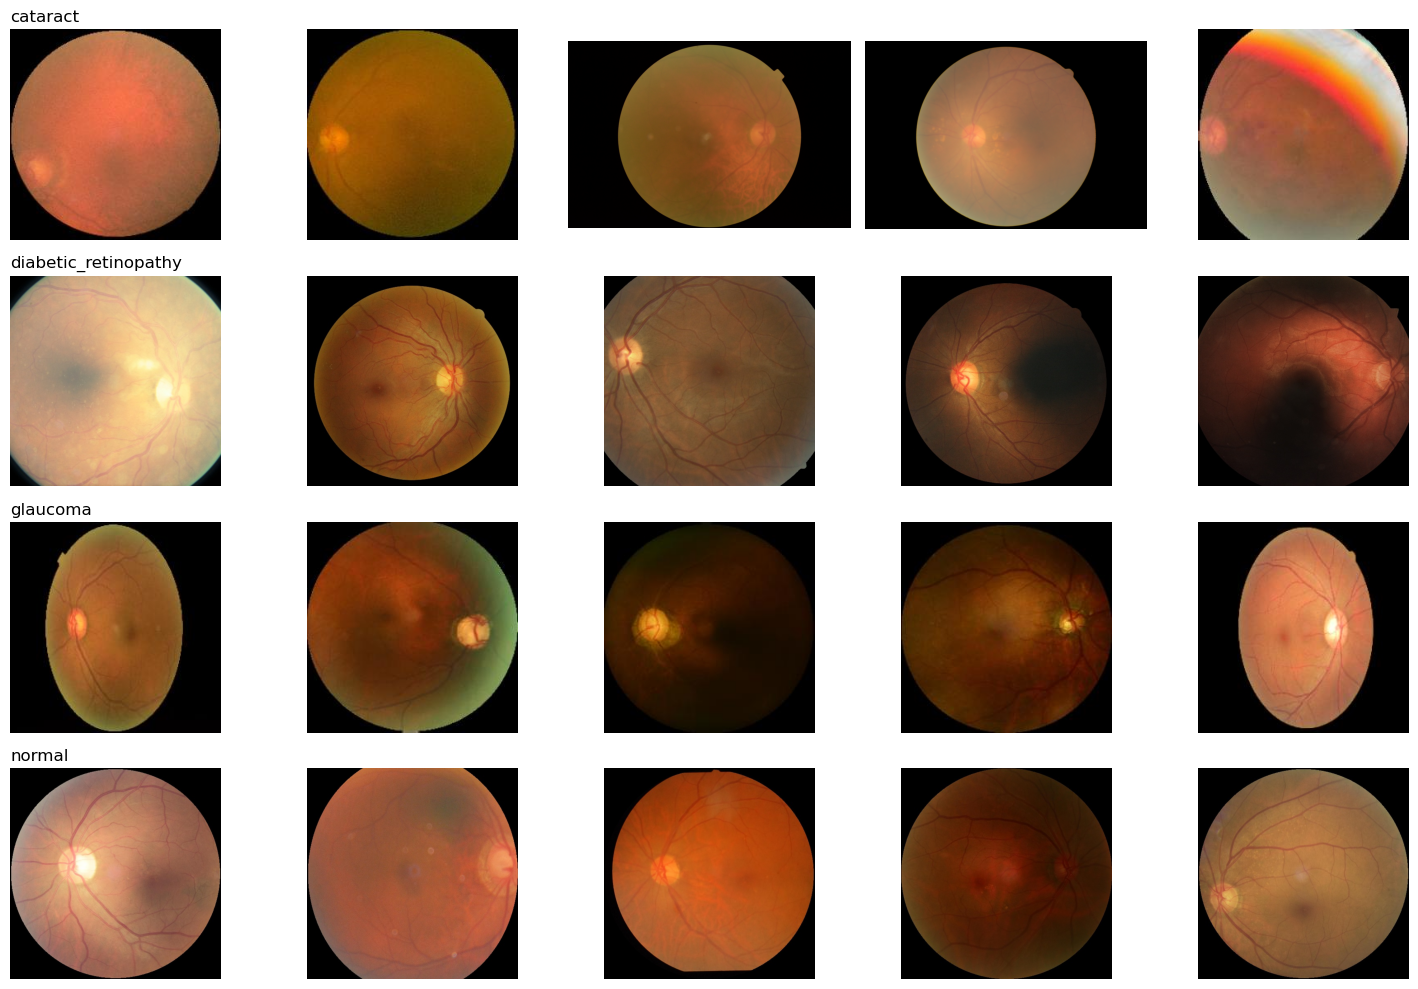

In [4]:
import cv2

def plot_sample_images(dataset_path, classes, num_samples=5):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        selected_images = random.sample(images, min(len(images), num_samples))

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=12, loc='left')

    plt.tight_layout()
    plt.show()
print("Menampilkan sampel gambar dari dataset train:")
plot_sample_images(train_path, classes, num_samples=5)

In [5]:
# Augmentasi Data Train Saja
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3372 images belonging to 4 classes.
Found 419 images belonging to 4 classes.
Found 426 images belonging to 4 classes.


# CNN 

In [6]:
# Model CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
#     Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

In [7]:
cnn_model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [8]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100
)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.2991 - loss: 1.3670 - val_accuracy: 0.4033 - val_loss: 1.3104
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.4492 - loss: 1.2695 - val_accuracy: 0.4511 - val_loss: 1.2543
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.4649 - loss: 1.2279 - val_accuracy: 0.4439 - val_loss: 1.2031
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.4543 - loss: 1.2108 - val_accuracy: 0.4535 - val_loss: 1.1724
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.4659 - loss: 1.1761 - val_accuracy: 0.4916 - val_loss: 1.1660
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.4904 - loss: 1.1610 - val_accuracy: 0.4845 - val_loss: 1.1389
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.5084 - loss: 1.1203 - val_accuracy: 0.5298 - val_loss: 1.1232
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.4821 - loss: 1.1239 - 

106/106 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7458 - loss: 0.6616 - val_accuracy: 0.7255 - val_loss: 0.7310
Epoch 100/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.7357 - loss: 0.6615 - val_accuracy: 0.7136 - val_loss: 0.7626


In [9]:
# Simpan model CNN
cnn_model.save("cnnuap_model.h5")

In [10]:
# Fungsi Visualisasi Grafik Hasil Latihan
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.legend()

    plt.show()

In [11]:
# Fungsi Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(title)
    plt.show()

In [12]:
# Evaluasi CNN
print("Evaluasi CNN")
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Evaluasi CNN
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7138 - loss: 0.7164
Test Accuracy: 75.35%


In [13]:
from sklearn.metrics import classification_report

# Evaluasi CNN model pada data test
y_pred_cnn = cnn_model.predict(test_generator)
y_pred_cnn_classes = y_pred_cnn.argmax(axis=1)

# Ground truth
y_true = test_generator.classes

# Classification report untuk CNN
print("Classification Report for CNN:")
print(classification_report(y_true, y_pred_cnn_classes, target_names=test_generator.class_indices.keys()))

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 505ms/step
Classification Report for CNN:
                      precision    recall  f1-score   support

            cataract       0.91      0.70      0.79       105
diabetic_retinopathy       0.89      0.84      0.86       111
            glaucoma       0.69      0.63      0.66       102
              normal       0.61      0.84      0.71       108

            accuracy                           0.75       426
           macro avg       0.78      0.75      0.75       426
        weighted avg       0.78      0.75      0.76       426



In [14]:
# Prediksi CNN
y_true = test_generator.classes
y_pred_cnn = np.argmax(cnn_model.predict(test_generator), axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 446ms/step


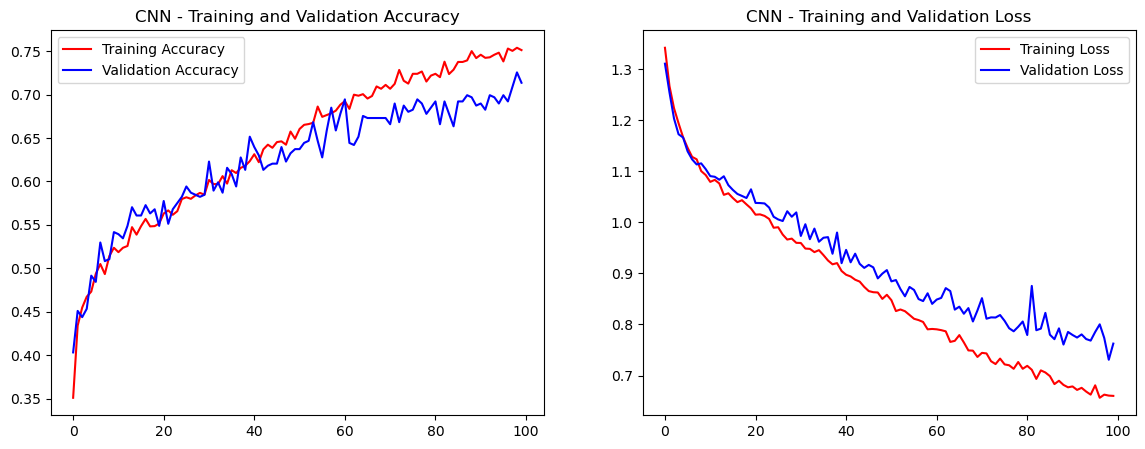

In [15]:
# Visualisasi CNN
plot_training_history(cnn_history, "CNN")

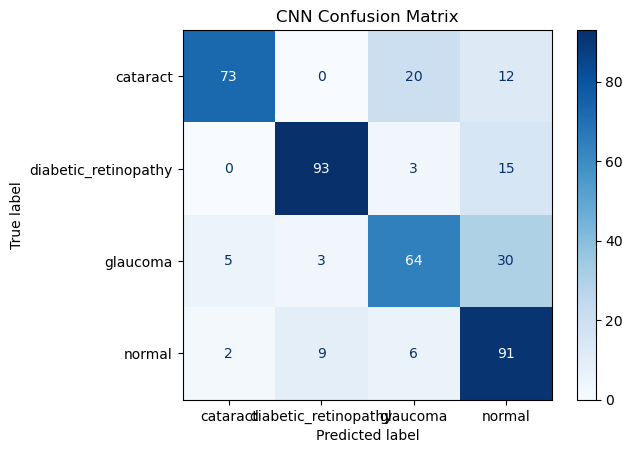

In [16]:
plot_confusion_matrix(y_true, y_pred_cnn, classes, "CNN Confusion Matrix")

# VGG19

In [17]:
# Model VGG19
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_base.trainable = False  # agar tidak ikut dilatih

vgg19_model = Sequential([
    vgg19_base,
    Flatten(),
    Dense(128, activation='relu'),
#     Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

In [18]:
vgg19_model.compile(optimizer=Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [19]:
# Pelatihan Model VGG19
vgg19_history = vgg19_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100
)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1051s 10s/step - accuracy: 0.3514 - loss: 1.4148 - val_accuracy: 0.5585 - val_loss: 1.1329
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1014s 10s/step - accuracy: 0.5876 - loss: 1.0644 - val_accuracy: 0.6205 - val_loss: 0.9785
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1009s 10s/step - accuracy: 0.6408 - loss: 0.9428 - val_accuracy: 0.5847 - val_loss: 1.0064
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1010s 10s/step - accuracy: 0.6605 - loss: 0.8907 - val_accuracy: 0.6635 - val_loss: 0.8390
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1007s 9s/step - accuracy: 0.6860 - loss: 0.8157 - val_accuracy: 0.6706 - val_loss: 0.7916
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1008s 10s/step - accuracy: 0.6830 - loss: 0.8012 - val_accuracy: 0.6897 - val_loss: 0.7437
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1009s 10s/step - accuracy: 0.7023 - loss: 0.7652 - val_accuracy: 0.6730 - val_loss: 0.7623
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1010s 10s/step - accuracy: 0.7167 - 

106/106 ━━━━━━━━━━━━━━━━━━━━ 997s 9s/step - accuracy: 0.8256 - loss: 0.4435 - val_accuracy: 0.6945 - val_loss: 0.7552
Epoch 100/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1010s 10s/step - accuracy: 0.8158 - loss: 0.4602 - val_accuracy: 0.8019 - val_loss: 0.5364


In [20]:
# Simpan model VGG19
vgg19_model.save("vgg19uap_model.h5")

In [21]:
# Evaluasi VGG19
print("Evaluasi VGG19")
test_loss_vgg, test_accuracy_vgg = vgg19_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy_vgg * 100:.2f}%")

Evaluasi VGG19
14/14 ━━━━━━━━━━━━━━━━━━━━ 112s 8s/step - accuracy: 0.7667 - loss: 0.5760
Test Accuracy: 77.23%


In [22]:
# Evaluasi VGG19 model pada data test
y_pred_vgg19 = vgg19_model.predict(test_generator)
y_pred_vgg19_classes = y_pred_vgg19.argmax(axis=1)

# Classification report untuk VGG19
print("Classification Report for VGG19:")
print(classification_report(y_true, y_pred_vgg19_classes, target_names=test_generator.class_indices.keys()))

14/14 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step
Classification Report for VGG19:
                      precision    recall  f1-score   support

            cataract       0.88      0.85      0.86       105
diabetic_retinopathy       0.90      0.79      0.84       111
            glaucoma       0.91      0.52      0.66       102
              normal       0.59      0.92      0.71       108

            accuracy                           0.77       426
           macro avg       0.82      0.77      0.77       426
        weighted avg       0.82      0.77      0.77       426



In [23]:
# Prediksi VGG19
y_pred_vgg = np.argmax(vgg19_model.predict(test_generator), axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 111s 8s/step


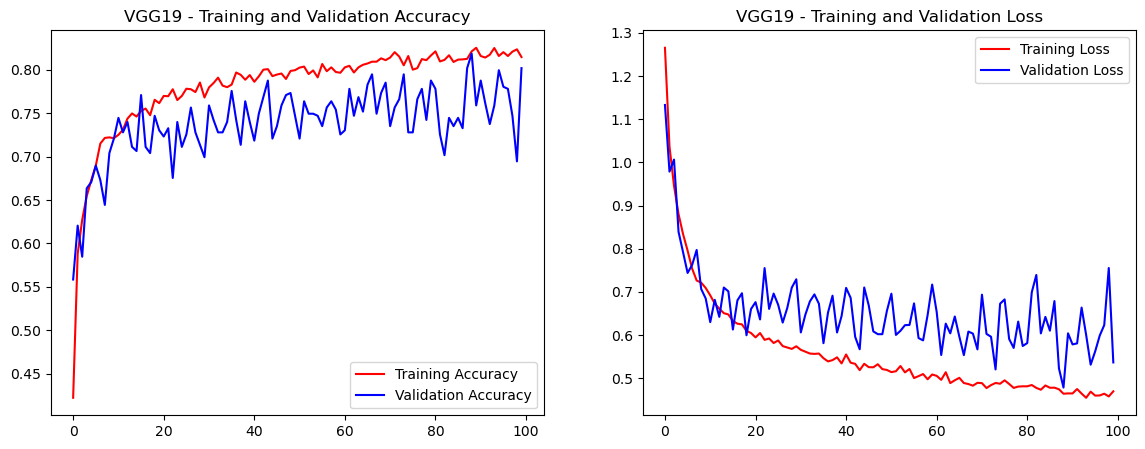

In [24]:
# Visualisasi VGG19
plot_training_history(vgg19_history, "VGG19")

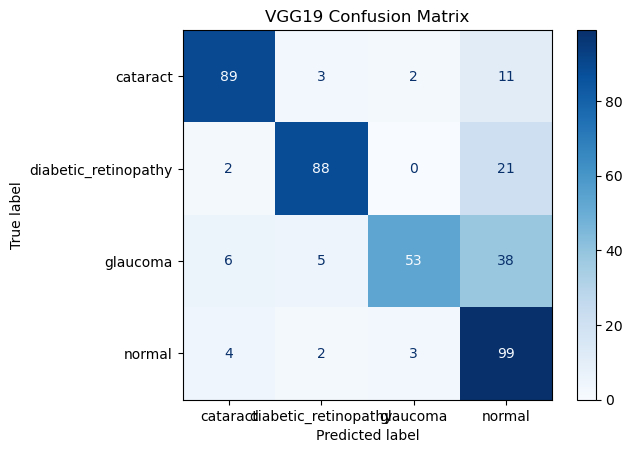

In [25]:
plot_confusion_matrix(y_true, y_pred_vgg, classes, "VGG19 Confusion Matrix")